In [ ]:
import pandas as pd
import os
from gensim import models
import random
import pickle
from tqdm import tqdm

from gensim import models
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import gensim.downloader as api

In [ ]:
book=pd.read_csv('../data/lemma_preprocessed/lemma_preprocessed.csv')
book.head(5)
def sent_to_word(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))
list_sentences=book.tags.values.tolist()
data_words=list(sent_to_word(list_sentences))
data_words[0]
#create dictionary
id2word=corpora.Dictionary(data_words)
texts=data_words
#term doc frequency
corpus=[id2word.doc2bow(text) for text in texts]
[[(id2word[i],freq) for i,freq in doc]for doc in corpus[:10]]

In [2]:
with open ('../models/corpus.pkl','rb') as corpus:
    corpus = pickle.load(corpus)

In [4]:
with open ('../models/id2word.pkl','rb') as id2word:
    id2word = pickle.load(id2word)

In [5]:
topicnums = [10, 15, 20, 25, 30, 35, 40, 45, 50]
project_folder = '../models'

ldamodels_bow = {}

# Create a progress bar
pbar = tqdm(total=len(topicnums), desc="Processing Topics")

for i in topicnums:
    random.seed(42)
    model_path = project_folder + f'/ldamodels_bow_{i}.lda'

    if not os.path.exists(model_path):
        # Update the progress bar description
        pbar.set_description(f"Processing Topics: {i}")

        %time ldamodels_bow[i] = models.LdaModel(corpus=corpus, num_topics=i, random_state=42, update_every=1, passes=10, id2word=id2word)
        ldamodels_bow[i].save(model_path)
        print(f'ldamodels_bow_{i}.lda created.')
    else:
        print(f'ldamodels_bow_{i}.lda already exists.')

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()


Processing Topics: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 752.07it/s]

ldamodels_bow_10.lda already exists.
ldamodels_bow_15.lda already exists.
ldamodels_bow_20.lda already exists.
ldamodels_bow_25.lda already exists.
ldamodels_bow_30.lda already exists.
ldamodels_bow_35.lda already exists.
ldamodels_bow_40.lda already exists.
ldamodels_bow_45.lda already exists.
ldamodels_bow_50.lda already exists.


In [6]:
lda_topics = {}
for i in topicnums:
    lda_model = models.LdaModel.load(project_folder+'/ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open(project_folder+'/pub_lda_bow_topics.pkl','wb'))

In [ ]:
lda_topics

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle

# Combine all word lists into a single list for vectorization
all_word_lists = [word for topics in lda_topics.values() for word_list in topics for word in word_list]

# Create a CountVectorizer and fit it on all words
vectorizer = CountVectorizer()
vectorizer.fit(all_word_lists)

# Convert word lists to BoW representation
lda_topics_bow = {num_topics: vectorizer.transform([' '.join(topic) for topic in topics]) for num_topics, topics in lda_topics.items()}

lda_stability_cosine = {}

for i in range(0, len(topicnums) - 1):
    cosine_sims = []
    
    for t1, topic1 in enumerate(lda_topics_bow[topicnums[i]]):
        sims = []
        
        for t2, topic2 in enumerate(lda_topics_bow[topicnums[i + 1]]):
            # Convert the BoW representations to numpy arrays for cosine_similarity
            topic1_array = topic1.toarray().reshape(1, -1)
            topic2_array = topic2.toarray().reshape(1, -1)
            
            # Calculate cosine similarity
            cosine_sim = cosine_similarity(topic1_array, topic2_array)[0][0]
            sims.append(cosine_sim)
        
        cosine_sims.append(sims)
    
    lda_stability_cosine[topicnums[i]] = cosine_sims

# Save the results using pickle
with open(project_folder + '/pub_lda_bow_stability_cosine.pkl', 'wb') as file:
    pickle.dump(lda_stability_cosine, file)


In [8]:
import os

file_path = project_folder + '/pub_lda_bow_stability_cosine.pkl'
print(os.path.exists(file_path))


True


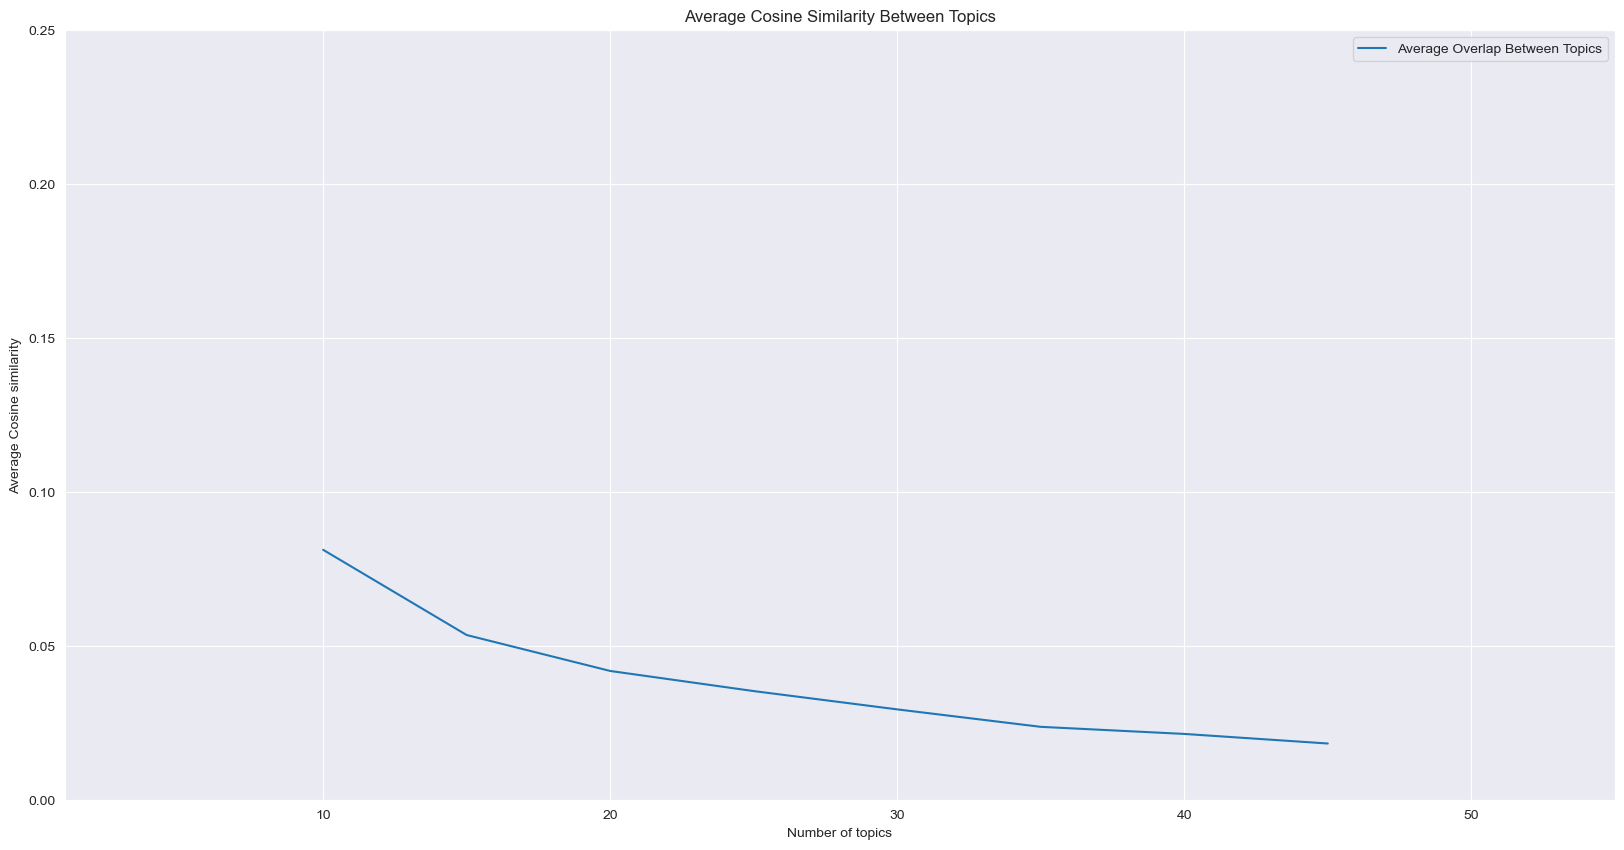

In [9]:
lda_stability = pickle.load(open(project_folder+'/pub_lda_bow_stability_cosine.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]
import matplotlib.pyplot as plt
import seaborn as sns
with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.figure(figsize=(20,10))
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlim([1, 55])
    plt.ylim([0, 0.25])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Cosine similarity')   
    plt.title('Average Cosine Similarity Between Topics')
    plt.legend()    
    plt.show()

In [10]:
num_topics = 35
lda_model_final = models.LdaModel.load(project_folder+'/ldamodels_bow_'+str(num_topics)+'.lda')

In [50]:
num_topics = 50
lda_model_final_50 = models.LdaModel.load(project_folder+'/ldamodels_bow_'+str(num_topics)+'.lda')

In [11]:
import joblib 
joblib.dump(lda_model_final,('../models/lda_model_final.joblib'))

['C:/Users/Binta Benny/Desktop/sem 3 project/saved_models/lda_model_final.joblib']

In [ ]:
#pip install numpy tensorflow pyLDAvis
# pip install --upgrade pyLDAvis gensim
# pip install pyLDAvis --upgrade

In [12]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [13]:
import pyLDAvis.gensim_models
from gensim.models import LdaModel
import pyLDAvis
import pickle
data = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, id2word)

# Display the visualization
pyLDAvis.display(data)


In [53]:
import pyLDAvis.gensim_models
from gensim.models import LdaModel
import pyLDAvis
import pickle
data = pyLDAvis.gensim_models.prepare(lda_model_final_50, corpus, id2word)

# Display the visualization
pyLDAvis.display(data)


In [14]:
#Coherence
from pprint import pprint
top_topics = lda_model_final.top_topics(corpus, topn=10)

avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

counter = 0
for topic in top_topics:
    print('Topic {}:'.format(counter))
    counter += 1
    pprint(topic)
    
pickle.dump(lda_topics,open(project_folder+'/pub_lda_bow_topics.pkl','wb'))


Average topic coherence: -3.3128.
Topic 0:
([(0.060580768, 'child'),
  (0.054652143, 'family'),
  (0.02249842, 'parent'),
  (0.021172946, 'love'),
  (0.018379802, 'young'),
  (0.0165398, 'school'),
  (0.016125068, 'mother'),
  (0.014331404, 'story'),
  (0.014196225, 'friend'),
  (0.013249991, 'life')],
 -1.7306348084299912)
Topic 1:
([(0.026086342, 'life'),
  (0.02248319, 'biography'),
  (0.02176316, 'story'),
  (0.017422745, 'american'),
  (0.01677304, 'autobiography'),
  (0.015186824, 'history'),
  (0.010337167, 'write'),
  (0.0096298205, 'man'),
  (0.009581906, 'america'),
  (0.009184979, 'work')],
 -1.795968111681166)
Topic 2:
([(0.03290789, 'fiction'),
  (0.02354321, 'man'),
  (0.016154688, 'love'),
  (0.01449069, 'woman'),
  (0.0131178405, 'life'),
  (0.0120728025, 'story'),
  (0.009563254, 'young'),
  (0.0070992573, 'father'),
  (0.006477514, 'family'),
  (0.00631836, 'tale')],
 -1.8644779913678127)
Topic 3:
([(0.02871304, 'learn'),
  (0.020940188, 'step'),
  (0.015639164, 'stud

In [15]:
corpus_lda_model = lda_model_final[corpus]
for article in corpus_lda_model[0]:
    print(article)


(1, 0.105953924)
(4, 0.15095769)
(5, 0.14429554)
(8, 0.04590386)
(11, 0.033357624)
(12, 0.022480313)
(18, 0.17920804)
(20, 0.17328517)
(23, 0.10647121)
(31, 0.022462942)
